Fitbit data for one individual.  Looks like a he/she left it off from time to time.  Assuming sleep and work for monday through friday, 2/3 of the day is sedentary.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import itertools
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire

In [2]:
# df1 = pd.read_csv('2018-04-26_and_2018-05-26.csv', nrows=31)
# df2 = pd.read_csv('2018-05-27_and_2018-06-26.csv', nrows=31)
# df3 = pd.read_csv('2018-06-27_and_2018-07-27.csv', nrows=31)
# df4 = pd.read_csv('2018-07-28_and_2018-08-26.csv', nrows=30)
# df5 = pd.read_csv('2018-08-27_and_2018-09-26.csv', nrows=31)
# df6 = pd.read_csv('2018-09-27_and_2018-10-27.csv', nrows=31)
# df7 = pd.read_csv('2018-10-28_and-2018-11-27.csv', nrows=31)
# df8 = pd.read_csv('2018-11-28_and_2018-12-28.csv', nrows=9)

In [3]:
# df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], join="inner", ignore_index=True)

I put above data into my acquire_fitbit_data function

In [4]:
df = acquire.get_fitbit_data()

In [5]:
df.shape

(225, 10)

In [6]:
df.head(1)

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566


In [7]:
df.tail(1)

,Date,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
224,12/6/18,"3,669","14,774",6.96,9,647,198,4,78,"1,962"


In [8]:
df.tail(1).index - df.head(1).index

Int64Index([224], dtype='int64')

In [9]:
224/3

74.66666666666667

Rename columns to make them easier to use

In [10]:
df = df.rename(columns = {'Date':'date', 'Calories Burned':'calories_burned', 'Steps':'steps', 'Distance':'distance', 'Floors':'floors', 'Minutes Sedentary':'minutes_sedentary', 'Minutes Lightly Active':'minutes_lightly_active', 'Minutes Fairly Active':'minutes_fairly_active', 'Minutes Very Active':'minutes_very_active', 'Activity Calories':'activity_calories'})
df.head(1)

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
0,4/26/18,"2,635","2,931",1.38,2,"1,347",93,0,0,566


Check to see if there are any nulls

Percent of the day the fitbit was not worn.  Muy importante

In [11]:
df.tail()

,date,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
220,12/2/18,"3,957","13,257",6.23,195,725,265,13,70,"2,305"
221,12/3/18,"3,660","12,915",6.12,6,782,219,40,51,"1,993"
222,12/4/18,"3,384","13,763",6.49,13,608,199,11,67,"1,663"
223,12/5/18,"3,670","13,865",6.52,12,739,200,12,69,"1,968"
224,12/6/18,"3,669","14,774",6.96,9,647,198,4,78,"1,962"


In [12]:
df.isna().sum()

date                      0
calories_burned           0
steps                     0
distance                  0
floors                    0
minutes_sedentary         0
minutes_lightly_active    0
minutes_fairly_active     0
minutes_very_active       0
activity_calories         0
dtype: int64

I had nulls at first and used the below code to fix them, but realized my nulls were due to importing an extra row that didn't exist in the 4th csv

In [13]:
# null_columns=df.columns[df.isnull().any()]
# print(df[df.isnull().any(axis=1)][null_columns].head())

In [14]:
# df.replace(np.nan, 0, inplace=True)

In [15]:
# df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d").dt.strftime('%Y-%m-%d')

Create the to_datetime object

In [16]:
df.date = pd.to_datetime(df.date)

In [17]:
df = df.set_index('date')

In [18]:
df.head(1)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,"2,635","2,931",1.38,2,"1,347",93,0,0,566


In [19]:
df.dtypes[df.dtypes == 'object']

calories_burned      object
steps                object
minutes_sedentary    object
activity_calories    object
dtype: object

Convert all objects into floats

In [20]:
df.calories_burned = df.calories_burned.astype(str)
df.calories_burned = df.calories_burned.str.replace(',', '').astype(float)

df.minutes_sedentary = df.minutes_sedentary.astype(str)
df.minutes_sedentary = df.minutes_sedentary.str.replace(',', '').astype(float)

df.activity_calories = df.activity_calories.astype(str)
df.activity_calories = df.activity_calories.str.replace(',', '').astype(float)

df.steps = df.steps.astype(str)
df.steps = df.steps.str.replace(',', '').astype(float)

In [21]:
df['percent_not_worn'] = ((1440 - (df.minutes_fairly_active + df.minutes_lightly_active + df.minutes_sedentary + df.minutes_very_active))/1440)*100

In [22]:
df['bmr'] = df.calories_burned - df.activity_calories

In [23]:
df['fairly_active_percentage'] = (df.minutes_fairly_active/1440)*100
df['sedentary_percentage'] = (df.minutes_sedentary/1440)*100
df['lightly_active_percentage'] = (df.minutes_lightly_active/1440)*100
df['very_active_percentage'] = (df.minutes_very_active/1440)*100

In [24]:
df.steps.describe()

count      225.000000
mean      8536.186667
std       5255.746608
min          0.000000
25%       4714.000000
50%       7806.000000
75%      12380.000000
max      25512.000000
Name: steps, dtype: float64

Manually Imputed the mean of steps and distance where zero in order to fill the holes of the graph of 'gait' over 'time'

In [25]:
df.steps[df.steps == 0] = df.steps.mean()
df.distance[df.distance == 0] = df.distance.mean()

In [26]:
df['gait'] =(df.distance * 5280)/df.steps

In [27]:
df.dtypes

calories_burned              float64
steps                        float64
distance                     float64
floors                         int64
minutes_sedentary            float64
minutes_lightly_active         int64
minutes_fairly_active          int64
minutes_very_active            int64
activity_calories            float64
percent_not_worn             float64
bmr                          float64
fairly_active_percentage     float64
sedentary_percentage         float64
lightly_active_percentage    float64
very_active_percentage       float64
gait                         float64
dtype: object

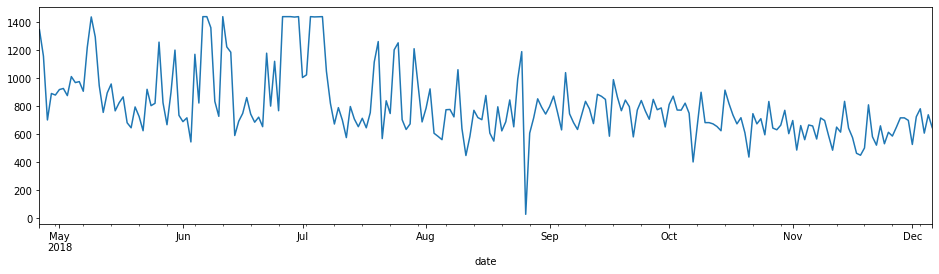

In [28]:
df.minutes_sedentary.resample('D').mean().plot(figsize=(16,4))

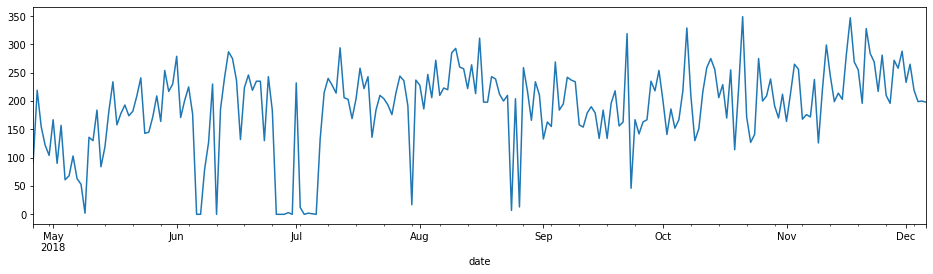

In [29]:
df.minutes_lightly_active.resample('D').mean().plot(figsize=(16,4))

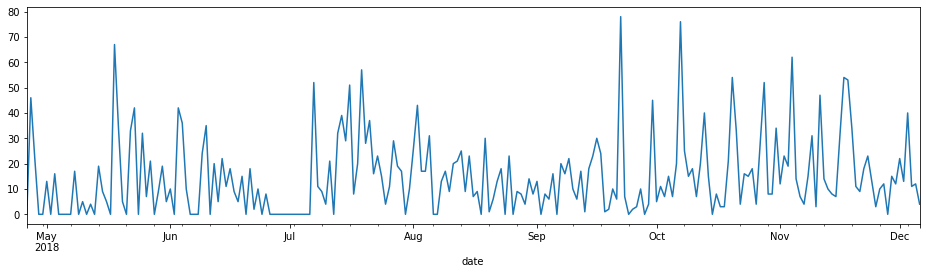

In [30]:
df.minutes_fairly_active.resample('D').mean().plot(figsize=(16,4))

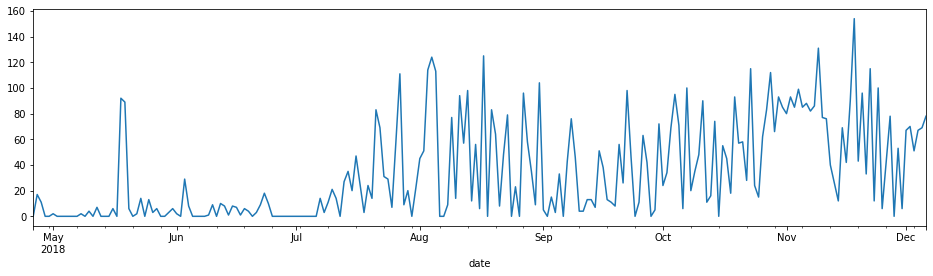

In [31]:
df.minutes_very_active.resample('D').mean().plot(figsize=(16,4))

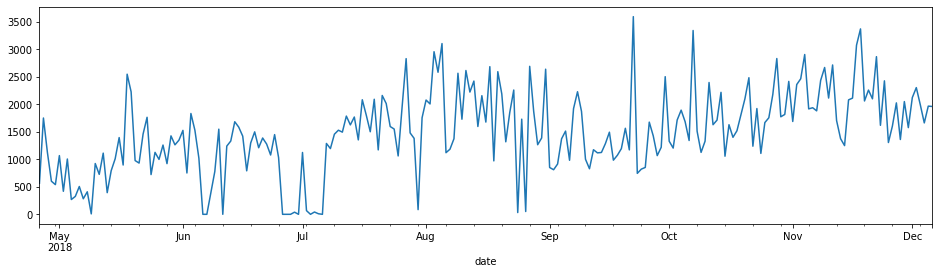

In [32]:
df.activity_calories.resample('D').mean().plot(figsize=(16,4))

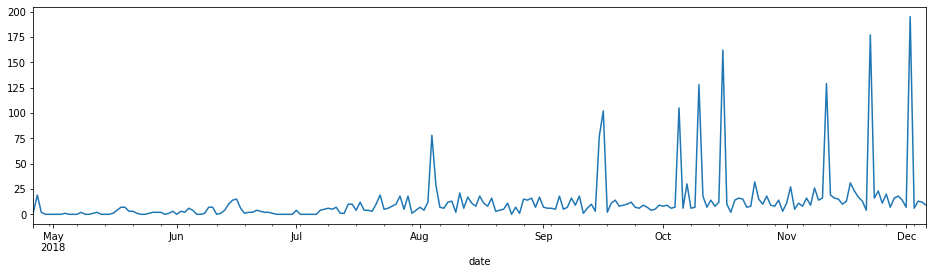

In [33]:
df.floors.resample('D').mean().plot(figsize=(16,4))

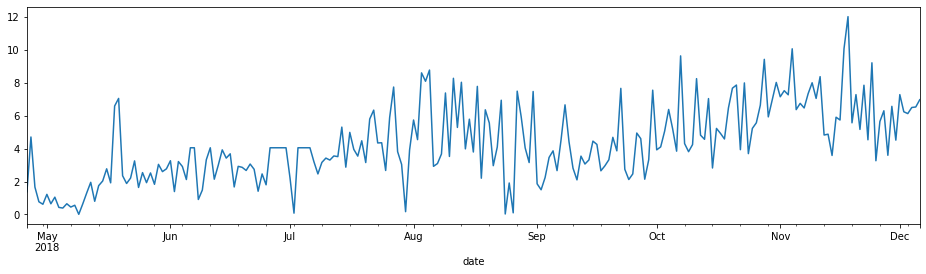

In [34]:
df.distance.resample('D').mean().plot(figsize=(16,4))

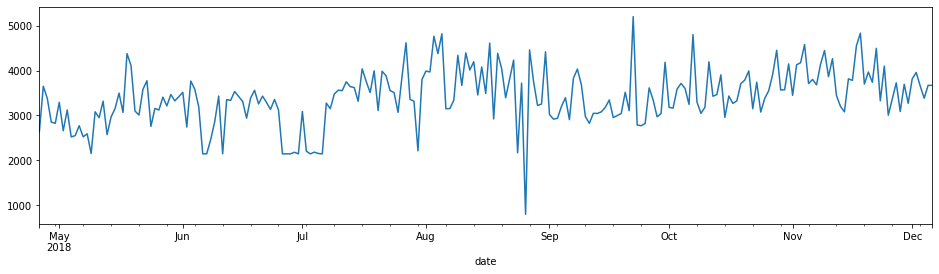

In [35]:
df.calories_burned.resample('D').mean().plot(figsize=(16,4))

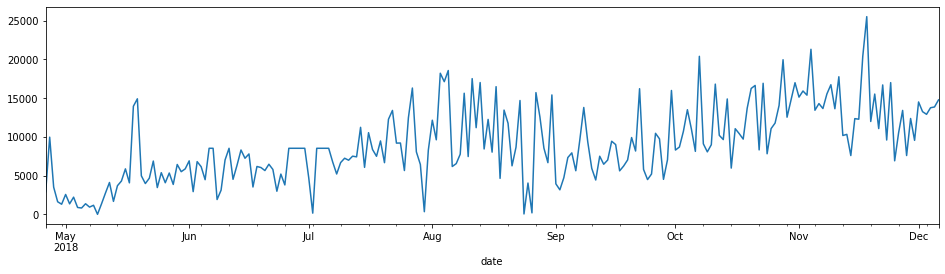

In [36]:
df.steps.resample('D').mean().plot(figsize=(16,4))

In [37]:
df.head()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,percent_not_worn,bmr,fairly_active_percentage,sedentary_percentage,lightly_active_percentage,very_active_percentage,gait
date,,,,,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2,1347.0,93,0,0,566.0,0.000000,2069.0,0.000000,93.541667,6.458333,0.000000,2.485977
2018-04-27,3649.0,9971.0,4.70,19,1158.0,219,46,17,1752.0,0.000000,1897.0,3.194444,80.416667,15.208333,1.180556,2.488818
2018-04-28,3379.0,3521.0,1.66,2,702.0,155,22,11,1124.0,38.194444,2255.0,1.527778,48.750000,10.763889,0.763889,2.489293
2018-04-29,2851.0,1639.0,0.77,0,891.0,122,0,0,602.0,29.652778,2249.0,0.000000,61.875000,8.472222,0.000000,2.480537
2018-04-30,2825.0,1323.0,0.62,0,880.0,104,0,0,540.0,31.666667,2285.0,0.000000,61.111111,7.222222,0.000000,2.474376


started jogging

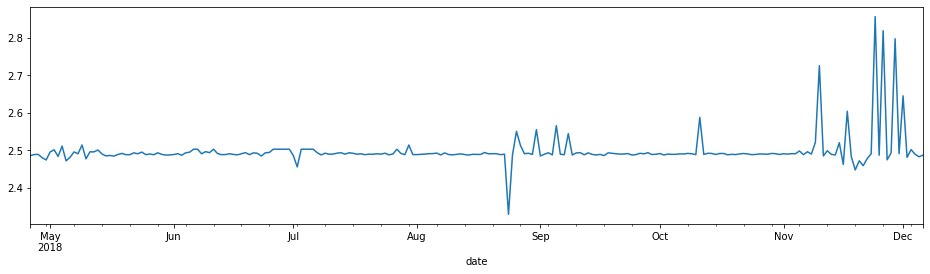

In [38]:
df.gait.resample('D').mean().plot(figsize=(16,4))

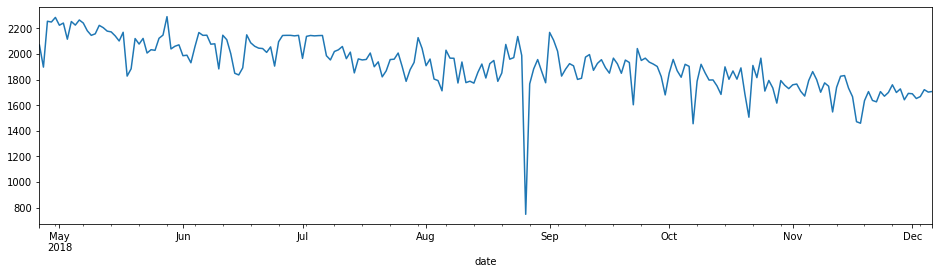

In [39]:
df.bmr.resample('D').mean().plot(figsize=(16,4))

Use this graph to select when to sample for model predictions

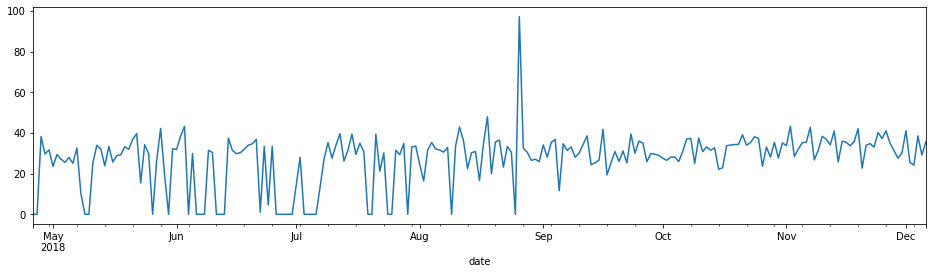

In [40]:
df.percent_not_worn.resample('D').mean().plot(figsize=(16,4))

## Split Data

Target Variables (9):
    - calories_burned
    - steps
    - distance
    - floors
    - minutes_sedentary
    - minutes_lightly_active
    - minutes_fairly_active
    - minutes_very_active
    - activity_calories

In [41]:
target_vars = ['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']

df1 = df[target_vars].resample('D').mean()
df2 = df[target_vars].resample('W').mean()
df3 = df[target_vars].resample('M').mean()

In [42]:
df1.head(1)

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2,1347.0,93,0,0,566.0


In [43]:
def split_store_data(df, train_prop=.66): 
    train_size = int(len(df) * train_prop)
    train, test = df[0:train_size].reset_index(), df[train_size:len(df)].reset_index()
    return train, test

In [44]:
train, test = split_store_data(df, train_prop=.66)

print('Observations: %d' % (len(df)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 225
Training Observations: 148
Testing Observations: 77


In [45]:
train = train.set_index('date')
test = test.set_index('date')

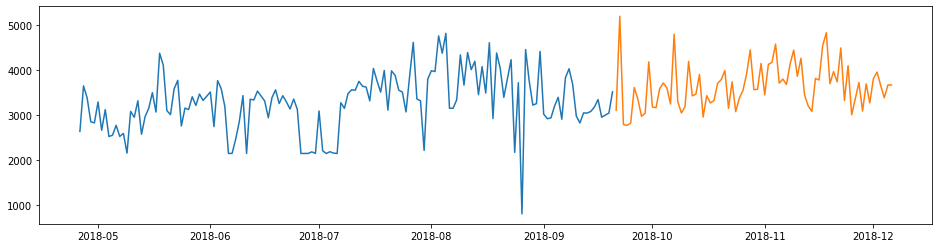

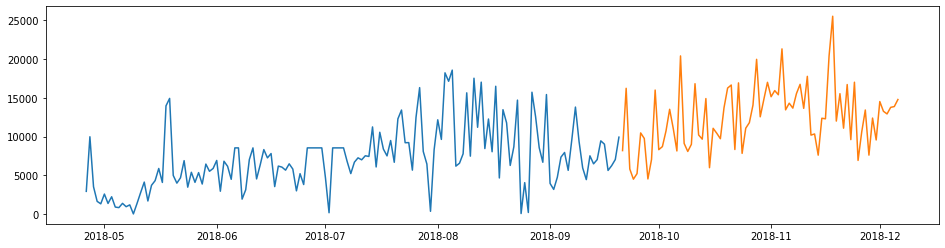

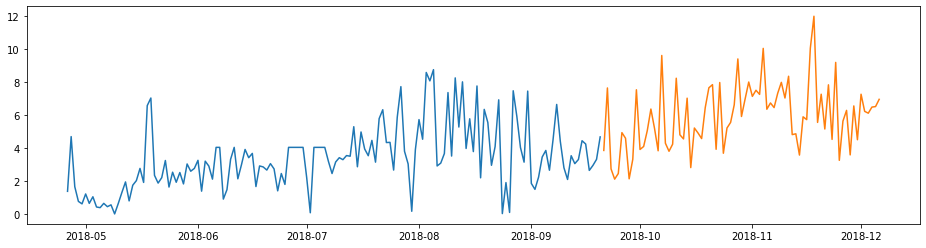

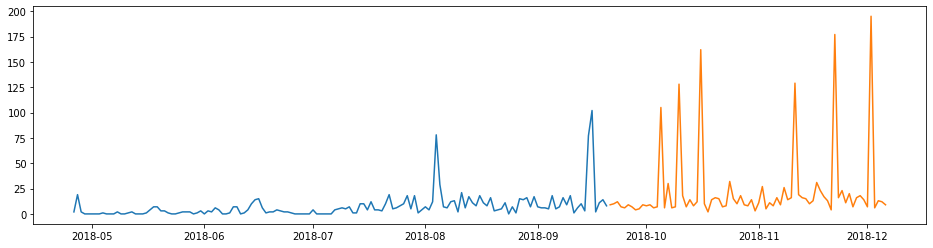

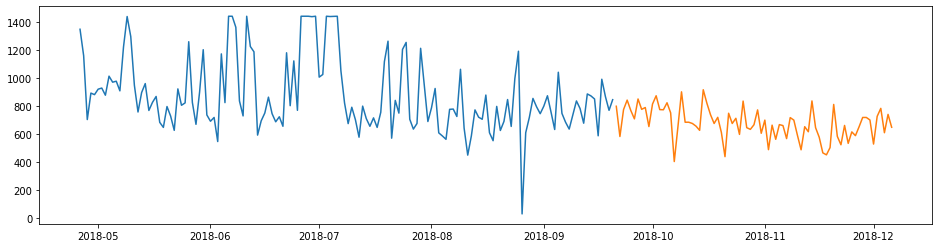

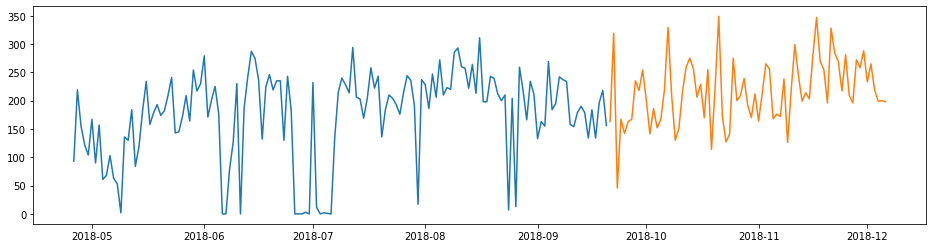

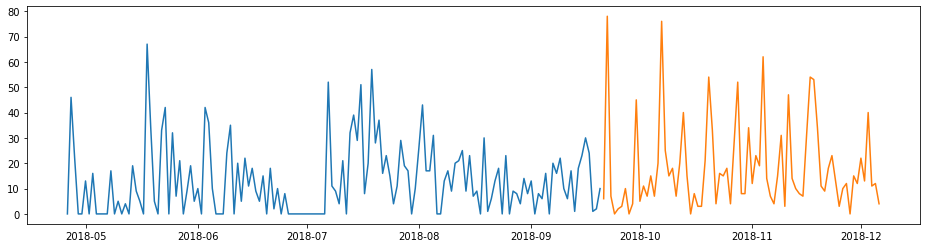

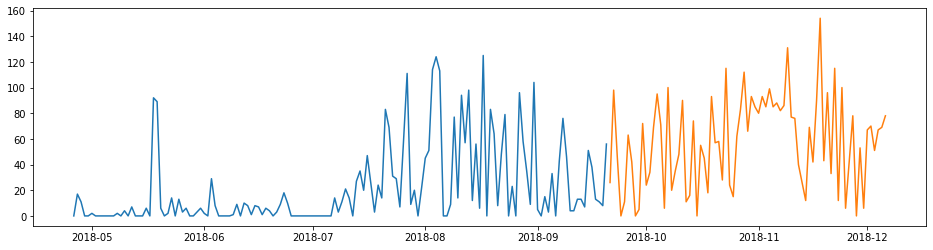

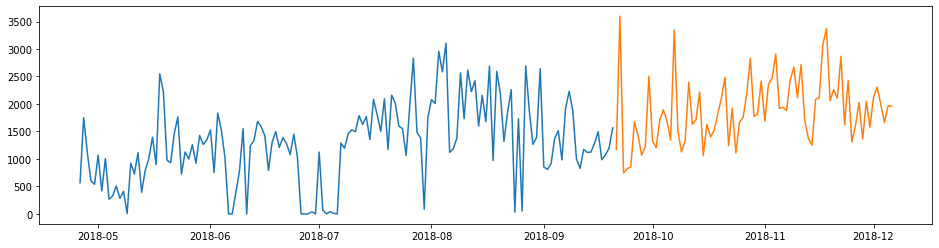

In [46]:
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train[target_vars[var]])
    plt.plot(test[target_vars[var]])
    plt.show()

In [47]:
yhat = train['2018-04-26':'2018-07-11'] + train['2018-04-26':'2018-12-06'].diff(1).mean()
# set the date (index) to be represent the date for our predictions
yhat.index = pd.date_range('2018-07-07', periods=len(yhat))
yhat


,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,percent_not_worn,bmr,fairly_active_percentage,sedentary_percentage,lightly_active_percentage,very_active_percentage,gait
2018-07-07,2641.0,2978.544218,1.402449,2.040816,1343.578231,93.428571,0.068027,0.380952,572.795918,0.176682,2068.204082,0.004724,93.304044,6.488095,0.026455,2.486011
2018-07-08,3655.0,10018.544218,4.722449,19.040816,1154.578231,219.428571,46.068027,17.380952,1758.795918,0.176682,1896.204082,3.199169,80.179044,15.238095,1.207011,2.488852
2018-07-09,3385.0,3568.544218,1.682449,2.040816,698.578231,155.428571,22.068027,11.380952,1130.795918,38.371126,2254.204082,1.532502,48.512377,10.793651,0.790344,2.489327
2018-07-10,2857.0,1686.544218,0.792449,0.040816,887.578231,122.428571,0.068027,0.380952,608.795918,29.829460,2248.204082,0.004724,61.637377,8.501984,0.026455,2.480571
2018-07-11,2831.0,1370.544218,0.642449,0.040816,876.578231,104.428571,0.068027,0.380952,546.795918,31.843348,2284.204082,0.004724,60.873488,7.251984,0.026455,2.474410
2018-07-12,3298.0,2628.544218,1.242449,0.040816,915.578231,167.428571,13.068027,2.380952,1074.795918,23.718348,2223.204082,0.907502,63.581822,11.626984,0.165344,2.495811
2018-07-13,2666.0,1419.544218,0.672449,0.040816,923.578231,90.428571,0.068027,0.380952,425.795918,29.551682,2240.204082,0.004724,64.137377,6.279762,0.026455,2.501492
2018-07-14,3127.0,2279.544218,1.072449,0.040816,872.578231,157.428571,16.068027,0.380952,1012.795918,27.329460,2114.204082,1.115835,60.595711,10.932540,0.026455,2.483905
2018-07-15,2528.0,951.544218,0.452449,1.040816,1008.578231,61.428571,0.068027,0.380952,275.795918,25.662793,2252.204082,0.004724,70.040155,4.265873,0.026455,2.511538
2018-07-16,2557.0,880.544218,0.412449,0.040816,965.578231,68.428571,0.068027,0.380952,332.795918,28.162793,2224.204082,0.004724,67.054044,4.751984,0.026455,2.472063


In [48]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()


In [49]:
train1 = train['2018-07-06':'2018-09-20']
test1 = test['2018-09-21':'2018-12-06']
print(len(train1))
print(len(test1))

77
77


calories_burned -- MSE: 897016.36 RMSE: 947.11
steps -- MSE: 72522998.56 RMSE: 8516.04
distance -- MSE: 16.53 RMSE: 4.07
floors -- MSE: 1871.28 RMSE: 43.26
minutes_sedentary -- MSE: 187152.76 RMSE: 432.61
minutes_lightly_active -- MSE: 16319.59 RMSE: 127.75
minutes_fairly_active -- MSE: 486.90 RMSE: 22.07
minutes_very_active -- MSE: 4080.16 RMSE: 63.88
activity_calories -- MSE: 1554153.71 RMSE: 1246.66


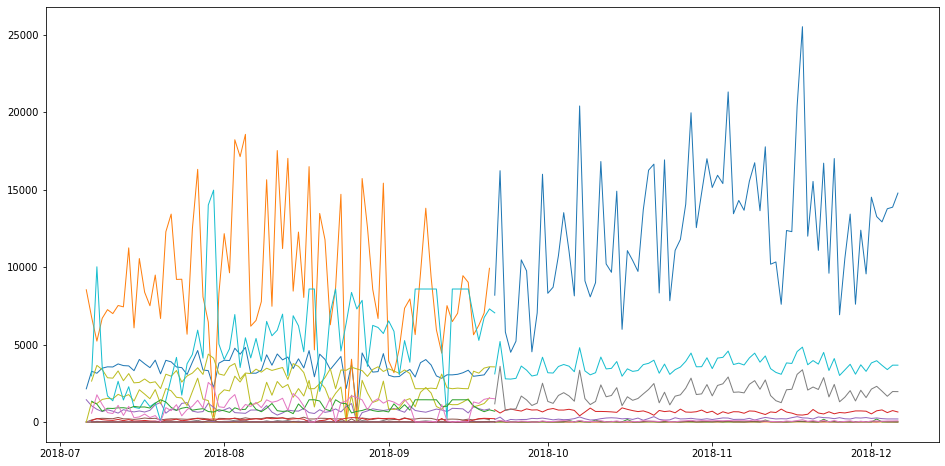

In [50]:
plot_and_eval(target_vars, train = train1, test = test1, linewidth=1)
# eval_df = append_eval_df(model_type='previous_year', target_vars=target_vars, train = train1, test = test1)

For Later, for filling yhat predictions

In [51]:
# dates = pd.date_range(start='12/7/18', end='12/20/18').to_frame()
# df = pd.merge(
#     df, dates, left_on='date', right_on=0,
#     how='outer').sort_values(by=['date']).drop(columns=0)

In [52]:
# df = df.fillna(value=0)

In [53]:
yhat = df['2018-09-01':'2018-12-06'] + df['2018-04-26':'2018-12-06'].diff(1).mean()
# set the date (index) to be represent the date for our predictions
yhat.index = pd.date_range('2018-12-07', periods=len(yhat))
yhat.tail()

,calories_burned,steps,distance,floors,minutes_sedentary,minutes_lightly_active,minutes_fairly_active,minutes_very_active,activity_calories,percent_not_worn,bmr,fairly_active_percentage,sedentary_percentage,lightly_active_percentage,very_active_percentage,gait
2019-03-09,3961.616071,13309.870536,6.254911,195.03125,721.875,265.46875,13.017857,70.348214,2311.232143,25.645151,1650.383929,0.904018,50.130208,18.435330,4.885293,2.481292
2019-03-10,3664.616071,12967.870536,6.144911,6.03125,778.875,219.46875,40.017857,51.348214,1999.232143,24.325707,1665.383929,2.779018,54.088542,15.240885,3.565848,2.502027
2019-03-11,3388.616071,13815.870536,6.514911,13.03125,604.875,199.46875,11.017857,67.348214,1669.232143,38.700707,1719.383929,0.765129,42.005208,13.851997,4.676959,2.489812
2019-03-12,3674.616071,13917.870536,6.544911,12.03125,735.875,200.46875,12.017857,69.348214,1974.232143,29.325707,1700.383929,0.834573,51.102431,13.921441,4.815848,2.482920
2019-03-13,3673.616071,14826.870536,6.984911,9.03125,643.875,198.46875,4.017857,78.348214,1968.232143,35.784040,1705.383929,0.279018,44.713542,13.782552,5.440848,2.487403


## USING A SMALLER, MORE STABLE DATA SET


In [54]:
df_small = df['2018-09-01':]
train_small, test_small = split_store_data(df_small, train_prop=.66)
print('Observations: %d' % (len(df_small)))
print('Training Observations: %d' % (len(train_small)))
print('Testing Observations: %d' % (len(test_small)))

Observations: 97
Training Observations: 64
Testing Observations: 33


In [55]:
train_small = train_small.set_index('date')
test_small = test_small.set_index('date')

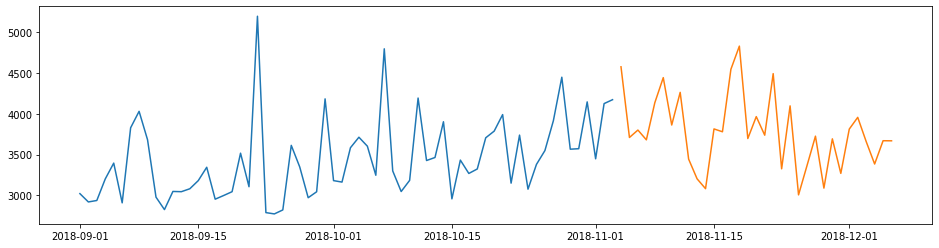

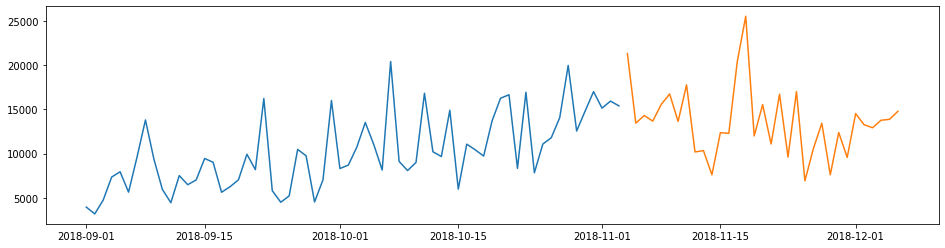

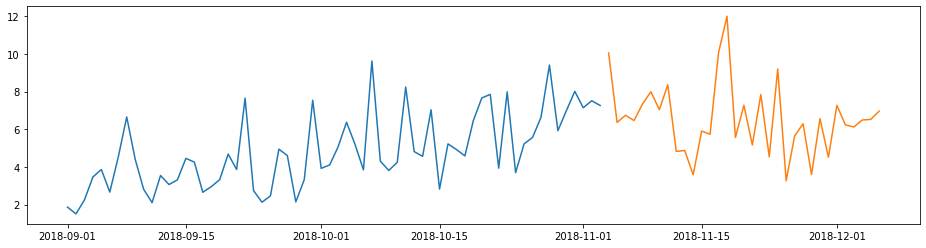

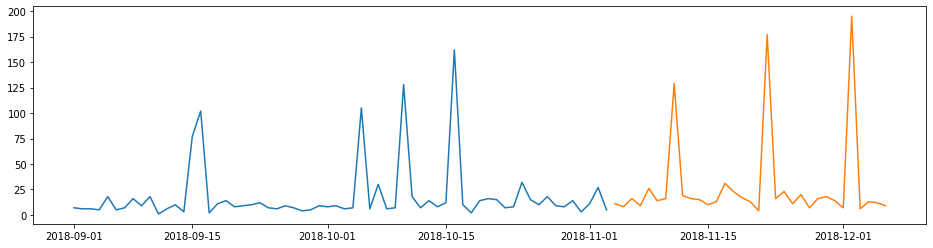

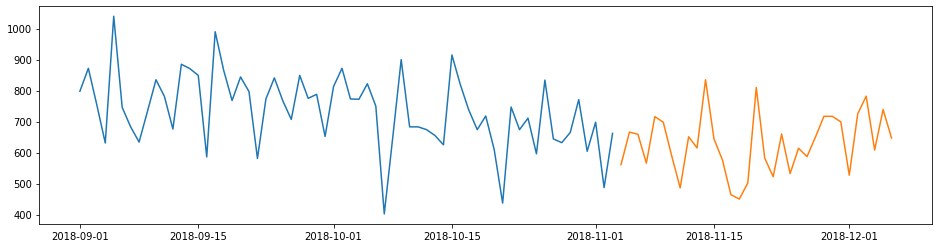

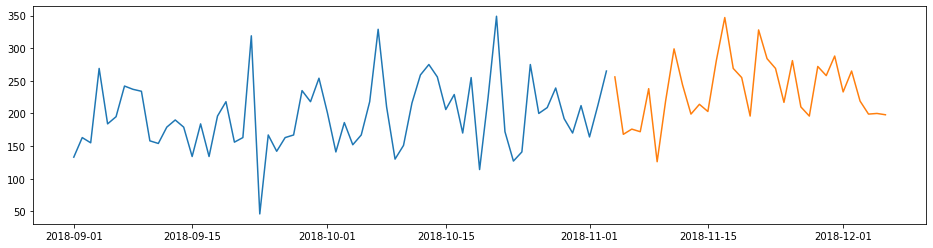

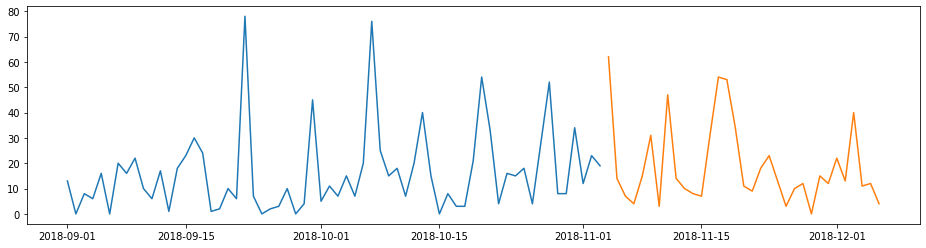

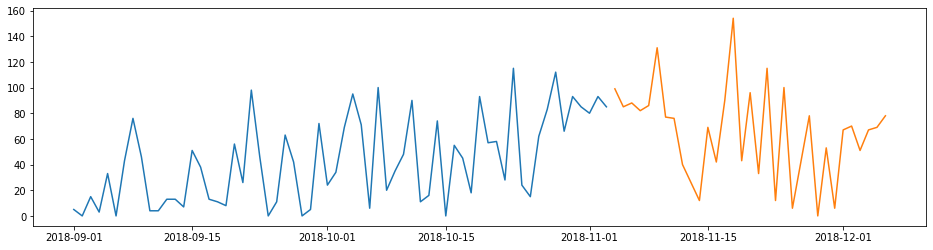

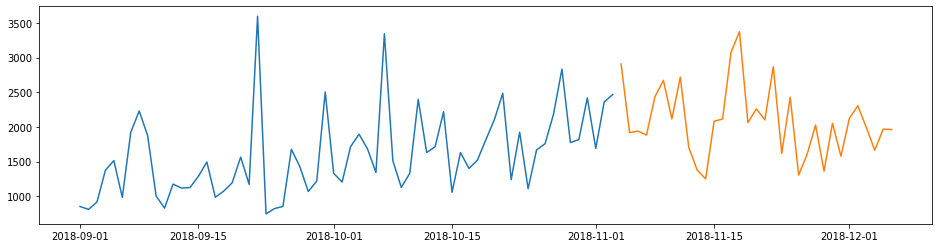

In [56]:
target_vars = ['calories_burned', 'steps', 'distance', 'floors', 'minutes_sedentary', 'minutes_lightly_active', 'minutes_fairly_active', 'minutes_very_active', 'activity_calories']
for var in range(len(target_vars)):
    plt.figure(figsize=(16, 4))
    plt.plot(train_small[target_vars[var]])
    plt.plot(test_small[target_vars[var]])
    plt.show()

In [57]:
yhat_small = pd.DataFrame(test_small[target_vars])
len(yhat_small)

33

In [58]:
for var in target_vars:
    yhat_small[var] = int(train_small[var][-1:])

In [59]:
for var in target_vars:
    print(var, ":", yhat_small[var].min() == yhat_small[var].max())

calories_burned : True
steps : True
distance : True
floors : True
minutes_sedentary : True
minutes_lightly_active : True
minutes_fairly_active : True
minutes_very_active : True
activity_calories : True


ValueError: Found input variables with inconsistent numbers of samples: [33, 97]

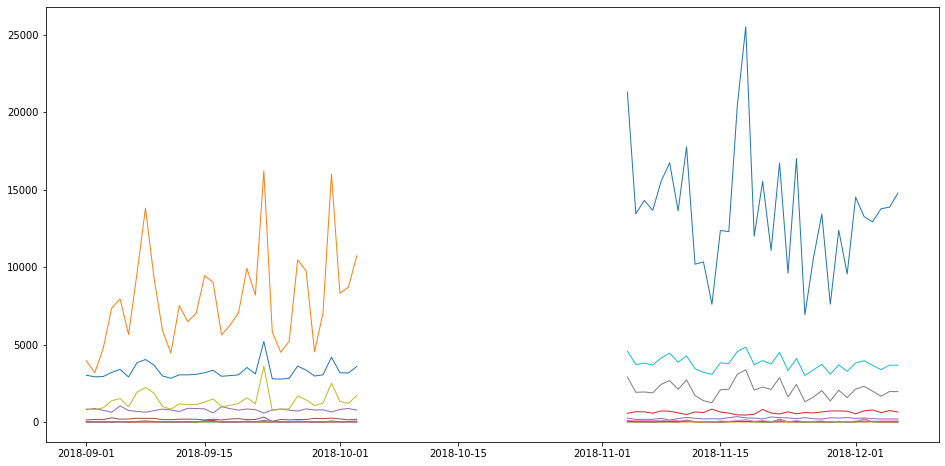

In [60]:
plot_and_eval(target_vars=target_vars, train = train_small[:33], test = test_small)

In [ ]:
yhat = train_small['2018-11-04':'2018-12-06'] + train_small['2018-11-04':'2018-12-06'].diff(1).mean()
# set the date (index) to be represent the date for our predictions
yhat.index = pd.date_range('2018-07-07', periods=len(yhat))
yhat

In [ ]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train', linewidth=1)
    plt.plot(test[target_vars], label='Test', linewidth=1)

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [ ]:
train5 = train_small['2018-10-02': '2018-11-03']
test5 = test_small['2018-11-04':'2018-12-06']
# print(len(train5))
# print(len(test5))
len(test5)

In [ ]:
plot_and_eval(target_vars, train = train5, test = test5, linewidth=1)

In [ ]:
yhat.calories_burned.resample('D').mean().plot(figsize=(16,4))

In [ ]:
df.calories_burned.resample('D').mean().plot(figsize=(16,4))